#Análise do conjunto pneu e suspensão de uma Hilux

In [4]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np

# Função de transferência em malha aberta

In [43]:
# Função de transferência em malha aberta

km1 = 9*(10**4) # constante da mola1 rigidez do pneu
km2 = 6*(10**4) # constante da mola2 rigidez do amortecedor

km = (km1*km2)/(km2+km1) # constante elástica efetiva

fv = 3*(10**3) # constante de amortecimento

m1 = 40 # massa não suspensa, roda
m2 = 2570/4  # massa suspensa, 1/4 carro
massa = (m1*m2)/(m1 + m2) # massa reduzida

Wn = np.sqrt(km/massa);
eta = (fv/massa)/(2*Wn)

print('Wn e ata = ', [Wn, eta])
Tsim = 5 # duração da simulação

numerador = [km1*fv, km1*km2] # cada termo adicionado resultará no aumento do grau do polinômio, ex 2 termos: é s^1 e s^0
denominador = [m1*m2, (m1+m2)*fv, ((km1*m2)+(m1+m2)*km2), km1*fv, km1*km2] # polinômio de 4° grau, vai gerar uma FT de 4° grau. 5 termos = polinômio de 4° grau

P_s = ctl.tf(numerador, denominador) #função de transferência de malha aberta
P_s

Wn e ata =  [30.919753045661103, 1.2883230435692128]


TransferFunction(array([ 270000000, 5400000000]), array([2.5700e+04, 2.0475e+06, 9.8775e+07, 2.7000e+08, 5.4000e+09]))

#Polos

In [44]:
#Polos
pG1s = ctl.pole(P_s)
pG1s

array([-39.01116889+46.21220621j, -39.01116889-46.21220621j,
        -0.82346146 +7.53465648j,  -0.82346146 -7.53465648j])

In [45]:
print("Polos da Função de Transferência")
print(f"Real[G(s)]: {np.real(pG1s)}")
print(f"Imag[G(s)]: {np.imag(pG1s)}")

Polos da Função de Transferência
Real[G(s)]: [-39.01116889 -39.01116889  -0.82346146  -0.82346146]
Imag[G(s)]: [ 46.21220621 -46.21220621   7.53465648  -7.53465648]


Polos da Função de Transferência
Real[G(s)]: [-39.01116889 -39.01116889  -0.82346146  -0.82346146]
Imag[G(s)]: [ 46.21220621 -46.21220621   7.53465648  -7.53465648]


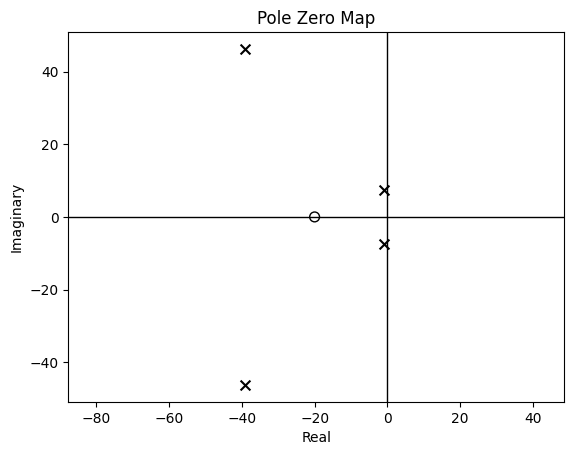

In [46]:
poleG1s, zeroG1s = ctl.pzmap(P_s, plot=True, grid=False, title='Pole Zero Map')
print("Polos da Função de Transferência")
print(f"Real[G(s)]: {np.real(poleG1s)}")
print(f"Imag[G(s)]: {np.imag(poleG1s)}")

#Estabilidadde

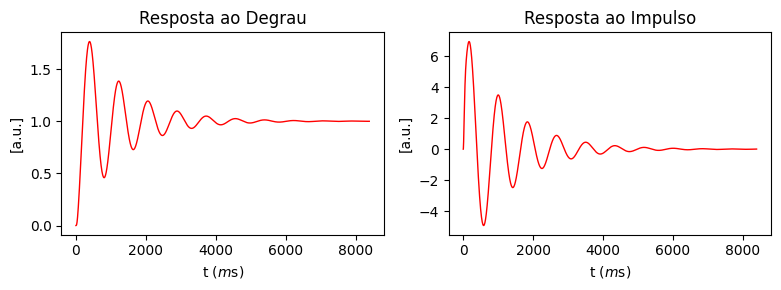

In [47]:
#Estabilidadde
t, y = ctl.step_response(P_s)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))
ax[0].plot(t*1e3,y,'r',linewidth=1)
ax[0].set_title("Resposta ao Degrau")
ax[0].set_xlabel("t ($m$s)")
ax[0].set_ylabel("[a.u.]")

t, y = ctl.impulse_response(P_s)
ax[1].plot(t*1e3,y,'r',linewidth=1)
ax[1].set_title("Resposta ao Impulso")
ax[1].set_xlabel("t ($m$s)")
ax[1].set_ylabel("[a.u.]")
plt.show()

# Controlador PID

In [271]:
# Controlador PID
Ki = 100*Wn;
Kp = 20*Wn;
Kd = 1*Wn
C_s = ctl.tf([Kd,Kp,Ki],[100.,1.]) # polinômios do PID, função de transferência do controlador
C_s

TransferFunction(array([  30.91975305,  618.39506091, 3091.97530457]), array([100.,   1.]))

#Sensor unitário

In [272]:
#Sensor unitário
H_s = ctl.tf([1.],[1.])

#Função de transferência Malha Fechada

In [273]:
#Função de transferência MF
G1_s = ctl.feedback(ctl.series(C_s, P_s), H_s, sign = -1 ) #constroi a FT em malha fechada a partir das demais FT

G1_s

TransferFunction(array([8.34833332e+09, 3.33933333e+11, 4.17416666e+12, 1.66966666e+13]), array([2.57000000e+06, 2.04775700e+08, 1.82278808e+10, 3.61032108e+11,
       4.71443666e+12, 1.67020666e+13]))

In [274]:
#Resposta ao degrau
T, yout = ctl.step_response(P_s, Tsim) # resposta ao degrau para Tsim e P_s, Tsim = tempo de simulação
T_mf, yout_mf = ctl.step_response(G1_s, Tsim) # resposta ao degrau para Tsim e G1_s, T_mf vetor de tempo correspondente aos valores yout


In [275]:
# Calcula um degrau unitário, calcula um degrau entre -1 e Tsim, para comparar
T2 = np.linspace(-1.,Tsim, 1000)
degrau = np.ones_like(T2)
degrau[T2<0] = 0

Text(0.5, 1.0, 'Sistema de segunda ordem')

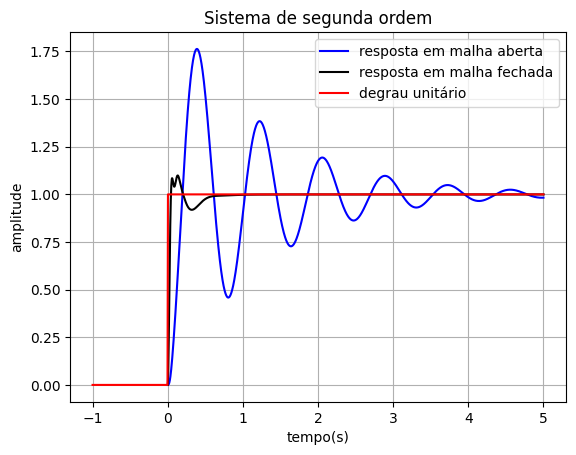

In [276]:
#plota os resultados
plt.plot(T,yout,'b-')
plt.plot(T_mf,yout_mf,'k-')
plt.plot(T2, degrau, 'r-')
plt.xlabel('tempo(s)')
plt.ylabel('amplitude')
plt.legend(['resposta em malha aberta','resposta em malha fechada','degrau unitário'])
plt.grid();plt.title('Sistema de segunda ordem')